# Data analysis of server(s) workload tasks

## Overview

In this notebook we are visualising the server workload over a time period. The workload is measured by the number of tasks running at a particular time point over a fixed period of time.

This visualisation looks at the workload under an ideal set of resources, i.e there is no wait time for tasks to run (turnaround time = execution time). This allows to visualise the dynamic workload on the system without concerning ourselves with scheduling algorithms and cost and resource utilisation optimisations.

## Interpreting the data

If we take a look at the Yahoo! trace, the provided format is `job_submission_time` `nr_of_tasks_in_job` `average_task_duration` `the_runtime_of_each_task`. This only allows us to model the "Job Arrival Process" \[1], ie. the Arrival Rate, Inter-arrival Time, and Actual Runtime. However, Job Cancellation is unknown and cannot be measured from these traces. Additionally, we can analyse the job modelling characteristics Bag Of Tasks, Burstiness, and Periodicity \[1]. "Job Execution Process" \[1] details such as Job Size (# Cores), Memory Usage, and User Behaviour are not recorded in the trace, and thus cannot be analysed.

## Problems with the trace data

When examining the `job_submission_time` and `the_runtime_of_each_task` fields of the trace, the time increment is not specified. This information is important to determine to accurately interperet the data. When looking at the source for the Yahoo! workload trace \[2], the  trace comes from a cluster of approximately 2000 machines at Yahoo! (YH trace), covers three weeks in late February 2009 and early March 2009, and contains around 30,000 jobs. It also details that the running time is in task-seconds of map and reduce functions. Thus, for the `the_runtime_of_each_task` field, we can make the assumption that the floating point number is in seconds. If we make the assumption that the `job_submission_time`, we would expect the last job submission time to be close to the number of seconds in 3 weeks, which is `60 x 60 x 24 x 7 x 3 = 1814400`. When looking at the last job record in the Yahoo! trace `YH.tr`, the `job_submission_time` is 181440, thus we can make the assumption that the submission time is measure in tens of seconds.

Unfortunately, when doing the same thing for the Facebook trace `FB.tr`, the last job record has a submit time of 388171, this is vastly different to the number of seconds in 6 months, which is approximately `60 x 60 x 24 x 30 x 6 = 15552000`. It also shares no regular pattern to the last job submit time. This issue of unknown time units must be resolved before analysing the Facebook trace, and potentially the other traces.

*\[1] F. Ian, "WORKLOAD CHARACTERISATION FOR CLOUD RESOURCE MANAGEMENT," School of Engineering Macquarie University, 2020, pp. 4-7.*
 
*\[2] Y. Chen, A. Ganapathi, R. Griffith and R. Katz, "The Case for Evaluating MapReduce Performance Using Workload Suites," 2011 IEEE 19th Annual International Symposium on Modelling, Analysis, and Simulation of Computer and Telecommunication Systems, 2011, pp. 390-399, doi: 10.1109/MASCOTS.2011.12.*

## Importing the data

The first step is to import the data from the `workload.csv` file. This file is generated from the `*.tr` trace files using the preprocessing script `process-trace.sh`. 

The `pandas` library is used to import the CSV file as a Dataframe. Pandas is a data science tool used for exploring and manipulating data. The `numpy` library is also imported to be used in conjuction with `pandas` to manipulate the Dataframe.

In [16]:
import numpy as np
import pandas as pd

with open('preprocessing/workload.csv') as file:
    data = pd.read_csv(file)

data['time'] = pd.to_timedelta(data['time'], unit="S")
# s = data.groupby(data['time'] // 60).nr_active_tasks.max()
# print(s)

## How the data looks

As we can see below, the `workload.csv` data has two fields: 'time', 'nr_active_tasks'.

Starting from time 0, each record contains a timestamp for either when a new task is run or when a task finishes running. This gives us a list of the number of active tasks over time.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992598 entries, 0 to 992597
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   time             992598 non-null  timedelta64[ns]
 1   nr_active_tasks  992598 non-null  int64          
dtypes: int64(1), timedelta64[ns](1)
memory usage: 15.1 MB


In [18]:
data.head()

,time,nr_active_tasks
0,0 days 00:00:00,0
1,0 days 00:01:15.270000,51
2,0 days 00:01:20.891168585,50
3,0 days 00:01:21.206010480,49
4,0 days 00:01:21.711536343,48


In [19]:
data.tail()

,time,nr_active_tasks
992593,21 days 00:16:55.223347540,4
992594,21 days 00:16:55.223347540,3
992595,21 days 00:16:55.223347540,2
992596,21 days 00:16:55.223347540,1
992597,21 days 00:16:55.223347540,0


## Statistics

Below are some general statistical mesaures of the data.

In [20]:
data['nr_active_tasks'].describe()

count    992598.000000
mean        630.378206
std         886.642952
min           0.000000
25%          42.000000
50%         277.000000
75%         871.000000
max        6792.000000
Name: nr_active_tasks, dtype: float64

## Plotting the workload

For ploting the data, the `matplotlib` is used to generate charts and plots of the workload. Here we are plotting the workload as the number of tasks running over the full time period. We can see that there is a high variability in the workload, with the workload for the Yahoo `YH.tr` having a spiky usage pattern. The resource consumption significantly alternates between peaks and troughs/valleys.

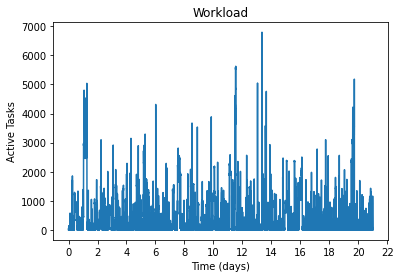

In [21]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

import timple

tmpl = timple.Timple()
tmpl.enable()

# locator = timple.timedelta.AutoTimedeltaLocator()
formattor = timple.timedelta.TimedeltaFormatter("%d")

# dates = data['time'] + np.datetime64('2000')

fig, ax = plt.subplots()
# ax.plot(dates, data['nr_active_tasks'], marker="")
ax.plot(data['time'], data['nr_active_tasks'], marker="")
ax.xaxis.set_major_formatter(formattor)
# ax.xaxis.set_major_locator(locator)
# fig.autofmt_xdate()
plt.xlabel("Time (days)")
plt.ylabel("Active Tasks")
plt.title("Workload")
plt.show()

### Workload sample for one day between the 2nd and 3rd days in the trace:

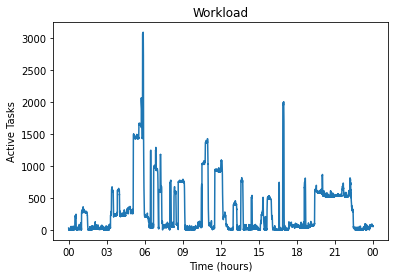

In [22]:
# firstDay = data[data['time'] <= np.timedelta64(1, 'D')]

oneDay = data.query('time > "2 days" and time < "3 days"')

# locator = timple.timedelta.AutoTimedeltaLocator()
formattor = timple.timedelta.TimedeltaFormatter("%h")
# dates = oneDay['time'] + np.datetime64('2000')

fig, ax = plt.subplots()
# ax.plot(dates, oneDay['nr_active_tasks'], marker="")
ax.plot(oneDay['time'], oneDay['nr_active_tasks'], marker="")
ax.xaxis.set_major_formatter(formattor)
# fig.autofmt_xdate()
plt.xlabel("Time (hours)")
plt.ylabel("Active Tasks")
plt.title("Workload")
plt.show()


In [32]:
# data.set_index("time",inplace=True)
# data.resample('100h').mean()
groupedData = data.copy()
# groupedData['time'] = groupedData['time'] + np.datetime64("2000")
groupedData.set_index("time",inplace=True)
groupedData = groupedData.resample('1h').median()
# groupedData = groupedData.asfreq(freq='10S', method='pad')
groupedData


,nr_active_tasks
time,
0 days 00:00:00,18.0
0 days 01:00:00,18.0
0 days 02:00:00,59.0
0 days 03:00:00,23.0
0 days 04:00:00,22.0
...,...
20 days 20:00:00,615.0
20 days 21:00:00,699.0
20 days 22:00:00,324.5


In [11]:
pd.Series()

<ipython-input-11-fa15c544da3b>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series()


Series([], dtype: float64)

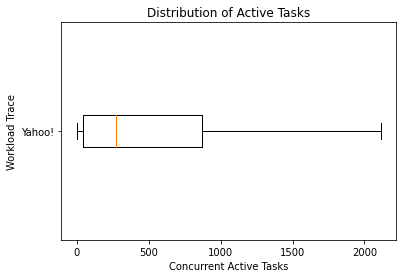

In [12]:
plt.boxplot(data['nr_active_tasks'], vert=False, labels=["Yahoo!"], showfliers=False)
plt.xlabel("Concurrent Active Tasks")
plt.ylabel("Workload Trace")
plt.title("Distribution of Active Tasks")
plt.show()